In [1]:
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array 
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
import shutil

In [2]:
with open("direct_data.json", "r") as file:
    negatives = json.load(file)

In [3]:
len(negatives)

23043

## Create positive dataset

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths
input_dir = "./lens"  # Replace with the actual input directory
output_file = "augmented_images.npy"

# Parameters
required_images = 3000
zoom_factor = 0.9

# Load original images
image_files = [f for f in os.listdir(input_dir) if f.endswith('.tiff')]
assert len(image_files) == 134, "Expected 134 images, but found {}".format(len(image_files))

images = []
for img_name in image_files:
    img_path = os.path.join(input_dir, img_name)
    img = load_img(img_path)
    img_array = img_to_array(img) / 255.0  # Normalize to 0-1
    images.append(img_array)

images = np.array(images)

# Augmentation settings
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=[zoom_factor, zoom_factor]  # Only zoom by 0.9
)

# Generate augmented images
augmented_images = []
num_augmented = 0

for img in images:
    img = np.expand_dims(img, axis=0)
    aug_iter = data_gen.flow(img, batch_size=1)
    for _ in range(int(required_images / len(images))):  # Ensure we reach 3000
        augmented_img = next(aug_iter)[0]
        augmented_images.append(augmented_img)
        num_augmented += 1
        if num_augmented >= required_images:
            break
    if num_augmented >= required_images:
        break

augmented_images = np.array(augmented_images)

# Save as stacked NumPy array
np.save(output_file, augmented_images)
print(f"Saved {augmented_images.shape[0]} augmented images to {output_file}")


Saved 2948 augmented images to augmented_images.npy


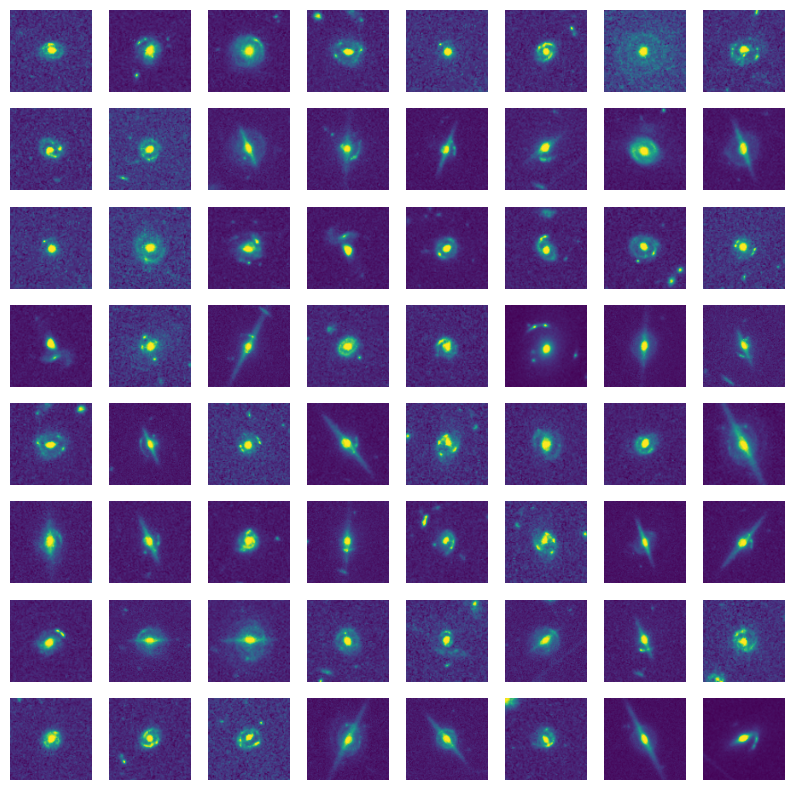

In [21]:
def visualize_images(positives, grid_size=8):
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < len(positives):
            img = Image.fromarray((positives[i] * 255).astype(np.uint8))
            ax.imshow(img)
            ax.axis('off')
    plt.show()

# Load and visualize first 64 images
visualize_images(positives[:64])

In [14]:
type(augmented_images)

numpy.ndarray

In [7]:
# Convert from 4D (num_images, height, width, 3) to 3D (num_images, height, width)
combined_images = np.mean(augmented_images, axis=-1)

# Save the new 3D array
np.save("combined_images.npy", combined_images)

print(f"Saved combined images with shape: {combined_images.shape}")


Saved combined images with shape: (2948, 96, 96)


In [8]:
edge_on_arrays = np.load('/data1/euclid_data/edge-on-spirals/edge_on_spiral_array.npy')

In [9]:
positives = np.concatenate((combined_images, edge_on_arrays), axis=0)

In [10]:
np.random.shuffle(positives)

[1.]


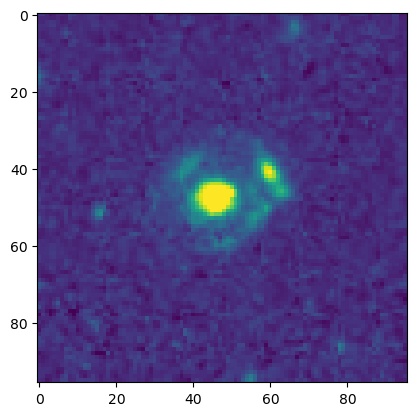

In [16]:
test_id = 351
plt.imshow(positives[test_id])
print(y_train[test_id])

In [12]:
len(positives)
positives = positives[:-3]

In [13]:
negatives = np.load('/home/rogerc8/large_code/retraining/init_datasets/final_negatives_dataset.npy')
negatives = negatives / 255.0
np.random.shuffle(negatives)
negatives = negatives[:5000]

In [2]:
positives = np.load('positives.npy')
negatives = np.load('negatives.npy')

In [3]:
positive_y = np.ones((len(positives),1), dtype=float)
negative_y = np.zeros((len(negatives),1), dtype=float)

In [4]:
X = np.concatenate((positives, negatives), axis=0)
X = np.expand_dims(X, axis=-1)

In [5]:
Y = np.concatenate((positive_y, negative_y), dtype=float)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=222)

In [20]:
print(f'Training set length: {len(x_train)}')
print(f'Testing set length: {len(x_test)}')

Training set length: 7700
Testing set length: 1925


In [19]:
x_train.shape

(7700, 96, 96, 1)

In [9]:
datagen = ImageDataGenerator(
    # rescale=True,
    )
batch_size = 5
train_iterator = datagen.flow(x_train, y_train, batch_size=batch_size)
test_iterator = datagen.flow(x_test, y_test, batch_size=batch_size)

In [10]:
model = load_model('thomas_model.keras', compile=False)

In [11]:
model.compile(  
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.AUC()
    ]
)

In [ ]:
model.fit(
    train_iterator,
    steps_per_epoch = 1540, 
    epochs = 25,
    validation_data = test_iterator,
    validation_steps = 385
)

In [ ]:
print(model.evaluate(x_test, y_test))